In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [2]:
import torch
import torch.nn as nn
from transformers import T5ForConditionalGeneration, T5Tokenizer
import datasets
from transformers import Trainer, TrainingArguments
import transformers
import matplotlib.pyplot as plt
import wandb

In [3]:
!wandb login 3a29512b4cab2036fbf6a236a1a929554a707208

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
# load prepared hf dataset from the disk
DATA_DIR = "../data/interim/hf_dataset/"
dataset = datasets.load_from_disk(DATA_DIR)

# remove features, which is useless for fine-tuning from the dataset
dataset = dataset.remove_columns(
    ["similarity", "lenght_diff", "trn_tox", "ref_tox", "__index_level_0__"]
)

In [5]:
# load pretrained model (T5 for text perephrasing), which I will finetune
checkpoint_name = 'SkolkovoInstitute/t5-paraphrase-paws-msrp-opinosis-paranmt'

model = T5ForConditionalGeneration.from_pretrained(checkpoint_name, device_map='auto')
tokenizer = T5Tokenizer.from_pretrained(checkpoint_name, legacy=False)

In [6]:
# tokenize translation to get true labels for training
def make_labels(example):
    example['labels'] = tokenizer(example["translation"], return_tensors="pt",
                                padding='max_length', truncation=True)['input_ids']
    example["labels"][example['labels'] == tokenizer.pad_token_id] = -100
    return example

# tokenize references to get input ids and attention mask for the model input
dataset = dataset.map(lambda x: tokenizer(x['reference'], return_tensors="pt", padding='max_length', truncation=True), num_proc=8)
dataset = dataset.map(make_labels, num_proc=8)
dataset.set_format('torch')

dataset

Map (num_proc=8):   0%|          | 0/548888 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/28889 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/548888 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/28889 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation', 'reference', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 548888
    })
    test: Dataset({
        features: ['translation', 'reference', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 28889
    })
})

In [7]:
def squeeze(example):
    example['labels'] = torch.squeeze(example['labels'])
    example['input_ids'] = torch.squeeze(example['input_ids'])
    example['attention_mask'] = torch.squeeze(example['attention_mask'])
    return example

dataset = dataset.map(squeeze, num_proc=8)

Map (num_proc=8):   0%|          | 0/548888 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/28889 [00:00<?, ? examples/s]

In [8]:
train_dataset = dataset['train']
val_dataset = dataset['test']

In [11]:
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)
training_args = TrainingArguments(
    output_dir='../models/T5_checkpointsV3',   # output directory
    overwrite_output_dir=False,
    num_train_epochs=3,             # total # of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,    # batch size for evaluation
    warmup_steps=300,               # number of warmup steps for learning rate scheduler
    weight_decay=0,                  # strength of weight decay
    learning_rate=3e-5,
    logging_dir='logs',           # directory for storing logs
    logging_steps=100,
    eval_steps=1000,
    evaluation_strategy='steps',
    save_steps=5000,
    report_to='wandb',
    bf16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [12]:
trainer.train()

Step,Training Loss,Validation Loss
1000,1.694800,1.587692
2000,1.664500,1.567106
3000,1.643900,1.552828
4000,1.634900,1.542156
5000,1.615700,1.535217
6000,1.620600,1.528746
7000,1.608300,1.523760
8000,1.605800,1.519435
9000,1.599800,1.516956
10000,1.586100,1.514449


TrainOutput(global_step=12864, training_loss=1.6241817094793367, metrics={'train_runtime': 32683.9207, 'train_samples_per_second': 50.381, 'train_steps_per_second': 0.394, 'total_flos': 1.0026954476067226e+18, 'train_loss': 1.6241817094793367, 'epoch': 3.0})

In [13]:
wandb.finish()

eval/loss,█▆▅▄▃▃▂▂▁▁▁▁
eval/runtime,▂█▁▁▅▄▆▂▁▂▁▇
eval/samples_per_second,▇▁██▄▅▃▇█▇█▂
eval/steps_per_second,▇▁██▄▅▃██▇█▂
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▆▆▆▅▅▄▄▅▄▄▄▃▃▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▁▁▂▁▂▁▂▁▂▂
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [14]:
trainer.save_model('../models/final_checkpointV3')

In [20]:
trainer.save_state()

In [15]:
log_history = trainer.state.log_history

In [16]:
log_history = log_history[:-1]

In [17]:
loss_history = []
eval_loss = []
for log in log_history:
    if 'loss' in log.keys():
        loss_history.append(log['loss'])
    if 'eval_loss' in log.keys():
        eval_loss.append(log['eval_loss'])

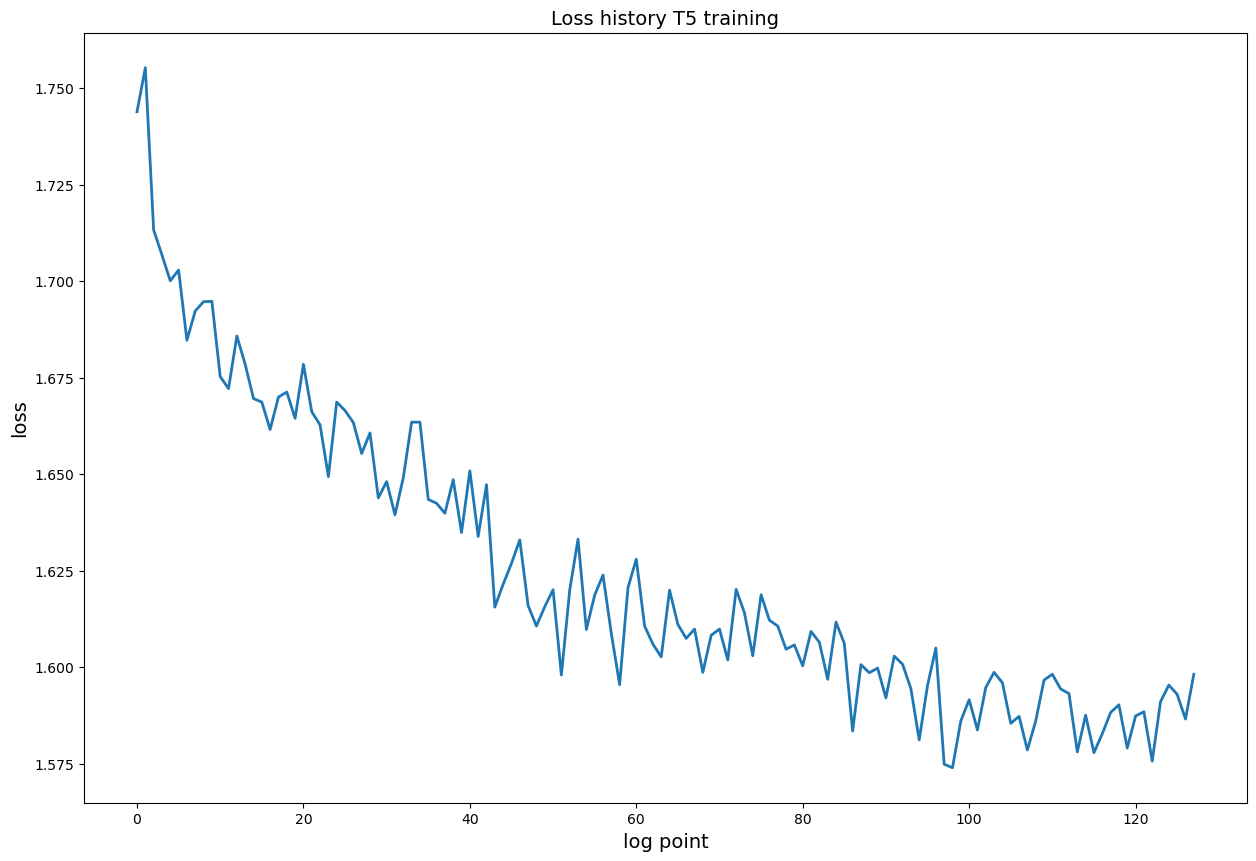

In [18]:
figure = plt.figure(figsize=(15,10))
plt.plot(loss_history, linewidth=2)
plt.xlabel('log point', fontsize=14)
plt.ylabel('loss',  fontsize=14)
plt.title('Loss history T5 training', fontsize=14)
plt.show()

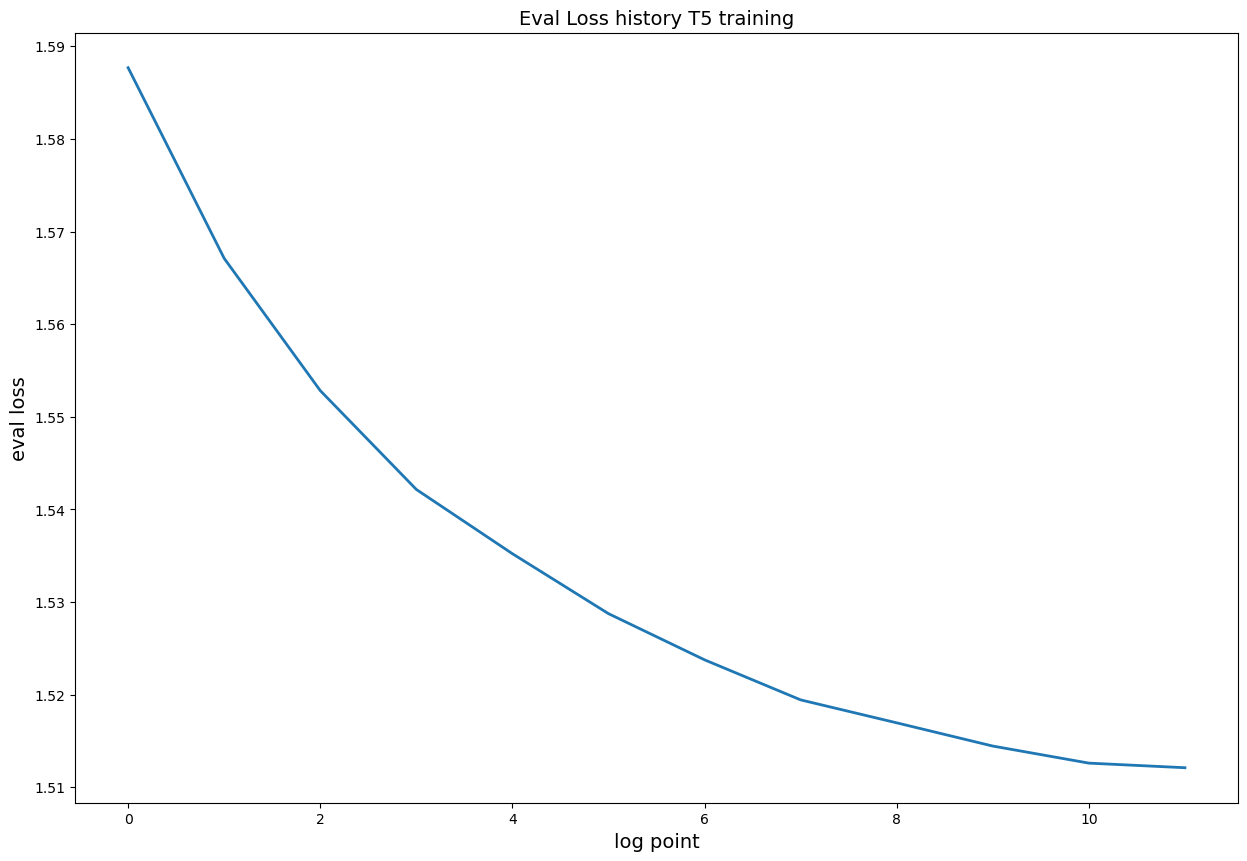

In [19]:
figure = plt.figure(figsize=(15,10))
plt.plot(eval_loss, linewidth=2)
plt.xlabel('log point', fontsize=14)
plt.ylabel('eval loss',  fontsize=14)
plt.title('Eval Loss history T5 training', fontsize=14)
plt.show()